<a href="https://colab.research.google.com/github/PsinY/RL-Term-Project/blob/main/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

트라이1

In [16]:
# Cell 1: 기본 설정

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt

# 재현성 위한 시드 고정
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [17]:
# Cell 2: 정류장 / 버스 / 도보 그래프 & 환경 정의

# -------------------------
# 1) 정류장 목록
# -------------------------

STOPS = [
    "집",
    "후암시장 정류장",
    "갈월동 정류장",
    "남영우체국 정류장",
    "갈월동사회복지회관 정류장",
    "숙명여대입구 정류장",
    "청파동주민센터",
    "숙명여대후문 정류장",
    "효창공원역 정류장",
    "남영동 정류장",
    "용문시장 정류장",
    "원효로2가 정류장",
    "원효로3가 정류장",
    "신용산역(중앙) 정류장",
    "신용산역 3번출구 정류장",
    "용산역광장 정류장",
    "한강대교북단(LGU+) 정류장",
    "한강대교북단 정류장",
    "원효대교북단 정류장",
    "신창동 정류장",
    "성심여고 정류장",
    "목적지",
]

STOP_TO_ID = {name: i for i, name in enumerate(STOPS)}
ID_TO_STOP = {i: name for name, i in STOP_TO_ID.items()}

# -------------------------
# 2) 도보 이동 간선 (일방향)
# -------------------------

WALK_EDGES_RAW = [
    ("집", "후암시장 정류장", 3),
    ("집", "갈월동 정류장", 11),

    ("남영우체국 정류장", "갈월동사회복지회관 정류장", 1),
    ("숙명여대입구 정류장", "청파동주민센터", 3),

    ("신용산역(중앙) 정류장", "신용산역 3번출구 정류장", 2),
    ("신용산역(중앙) 정류장", "용산역광장 정류장", 2),

    ("원효로2가 정류장", "용문시장 정류장", 2),

    ("용문시장 정류장", "목적지", 12),
    ("신창동 정류장", "목적지", 2),
    ("원효로3가 정류장", "목적지", 7),
    ("효창공원역 정류장", "목적지", 15),
    ("성심여고 정류장", "목적지", 1),
    ("원효대교북단 정류장", "목적지", 10),
]

WALK_EDGES = [
    (STOP_TO_ID[s1], STOP_TO_ID[s2], t)
    for (s1, s2, t) in WALK_EDGES_RAW
]

# -------------------------
# 3) 버스 노선 배차간격
# -------------------------

BUS_INTERVAL = {
    "400": 11,
    "605": 10,
    "용산02": 5,
    "1711": 7,
    "7016": 9,
    "162": 8,
    "503": 13,
    "262": 10,
    "0411": 14,
    "0017": 13,
    "5012": 13,
    "505": 9,
}

BUS_LINES = list(BUS_INTERVAL.keys())
MAX_INTERVAL = max(BUS_INTERVAL.values())

# -------------------------
# 4) 버스 이동 간선 (line, from, to, ride_min)
# -------------------------

BUS_EDGES = []

def add_bus_edge(line, from_stop, to_stop, ride_min):
    BUS_EDGES.append((
        line,
        STOP_TO_ID[from_stop],
        STOP_TO_ID[to_stop],
        ride_min,
    ))

# 400번 버스
add_bus_edge("400", "후암시장 정류장", "남영우체국 정류장", 4)
add_bus_edge("400", "후암시장 정류장", "숙명여대입구 정류장", 6)
add_bus_edge("400", "후암시장 정류장", "원효로2가 정류장", 21)
add_bus_edge("400", "후암시장 정류장", "숙명여대후문 정류장", 9)
add_bus_edge("400", "후암시장 정류장", "효창공원역 정류장", 16)

# 605번 버스
add_bus_edge("605", "후암시장 정류장", "신용산역(중앙) 정류장", 11)
add_bus_edge("605", "후암시장 정류장", "남영우체국 정류장", 4)
add_bus_edge("605", "후암시장 정류장", "한강대교북단(LGU+) 정류장", 13)

# 용산02
add_bus_edge("용산02", "갈월동사회복지회관 정류장", "남영동 정류장", 4)

# 1711
add_bus_edge("1711", "남영동 정류장", "용문시장 정류장", 6)
add_bus_edge("1711", "갈월동 정류장", "용문시장 정류장", 10)

# 7016
add_bus_edge("7016", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("7016", "남영동 정류장", "원효로3가 정류장", 8)

# 162
add_bus_edge("162", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("162", "남영동 정류장", "원효로3가 정류장", 8)
add_bus_edge("162", "갈월동 정류장", "원효로3가 정류장", 9)

# 503 (모두 13분)
add_bus_edge("503", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("503", "남영동 정류장", "원효로3가 정류장", 8)
add_bus_edge("503", "갈월동 정류장", "원효로3가 정류장", 9)

# 262
add_bus_edge("262", "청파동주민센터", "원효로3가 정류장", 7)

# 0411
add_bus_edge("0411", "숙명여대후문 정류장", "원효로3가 정류장", 12)

# 0017
add_bus_edge("0017", "신용산역 3번출구 정류장", "신창동 정류장", 12)
add_bus_edge("0017", "한강대교북단 정류장", "성심여고 정류장", 13)
add_bus_edge("0017", "용문시장 정류장", "신창동 정류장", 4)
add_bus_edge("0017", "용산역광장 정류장", "성심여고 정류장", 17)

# 505
add_bus_edge("505", "갈월동 정류장", "원효대교북단 정류장", 11)

# 5012
add_bus_edge("5012", "용산역광장 정류장", "원효대교북단 정류장", 6)

# -------------------------
# 5) ACTION 목록 구성
# -------------------------

ACTIONS = []

# walk actions
for s1, s2, w in WALK_EDGES:
    ACTIONS.append({
        "type": "walk",
        "from": s1,
        "to": s2,
        "walk": w,
    })

# bus actions
for line, s1, s2, ride in BUS_EDGES:
    ACTIONS.append({
        "type": "bus",
        "line": line,
        "from": s1,
        "to": s2,
        "ride": ride,
    })

TOTAL_ACTION_DIM = len(ACTIONS)

# from_stop 기준 가능한 action index
ACTIONS_BY_FROM = {i: [] for i in range(len(STOPS))}
for idx, a in enumerate(ACTIONS):
    ACTIONS_BY_FROM[a["from"]].append(idx)

print("총 정류장 수:", len(STOPS))
print("총 행동 수:", TOTAL_ACTION_DIM)
print("집에서 가능한 행동 수:", len(ACTIONS_BY_FROM[STOP_TO_ID["집"]]))

# -------------------------
# 6) 환경 클래스
# -------------------------

class BusEnv:
    """
    집 -> 목적지까지 이동하는 강화학습 환경.
    - 보상:
        * 매 스텝: -(walk + wait + ride)  (시간 최소화)
        * 에피소드 종료 시:
            - 도보 합계 > 10분: 초과구간 5분당 추가 패널티 -5, -10, -15, ...
            - 목적지 도착 시 +20 보너스
            - 목적지 미도달 시 -50 패널티
    """

    def __init__(self, max_steps=60, arrival_bonus=20.0):
        self.max_steps = max_steps
        self.arrival_bonus = arrival_bonus
        self.state_dim = len(STOPS) + 3 + len(BUS_LINES)
        self.reset()

    def reset(self):
        self.current_stop = STOP_TO_ID["집"]
        self.current_time = 0  # 분
        self.total_walk = 0
        self.total_wait = 0
        self.total_ride = 0
        self.total_time = 0
        self.done = False
        self.step_count = 0
        self.success = False
        return self._build_state()

    def _eta_for_line(self, line_name):
        interval = BUS_INTERVAL[line_name]
        # 현재 시각 기준 다음 버스까지 남은 시간
        eta = (interval - (self.current_time % interval)) % interval
        return eta

    def _build_state(self):
        stop_onehot = np.zeros(len(STOPS), dtype=np.float32)
        stop_onehot[self.current_stop] = 1.0

        time_feats = np.array([
            self.total_walk / 60.0,
            self.total_wait / 60.0,
            self.total_time / 60.0,
        ], dtype=np.float32)

        etas = np.array(
            [self._eta_for_line(line) / MAX_INTERVAL for line in BUS_LINES],
            dtype=np.float32
        )

        return np.concatenate([stop_onehot, time_feats, etas])

    def get_available_actions(self):
        return ACTIONS_BY_FROM.get(self.current_stop, [])

    def step(self, action_idx):
        assert not self.done, "Episode is done. Call reset()."

        self.step_count += 1
        a = ACTIONS[action_idx]

        add_walk = 0
        add_wait = 0
        add_ride = 0

        if a["type"] == "walk":
            add_walk = a["walk"]
            dt = add_walk
        else:
            wait = self._eta_for_line(a["line"])
            add_wait = wait
            add_ride = a["ride"]
            dt = wait + add_ride

        # 시간/누적치 업데이트
        self.current_time += dt
        self.total_walk += add_walk
        self.total_wait += add_wait
        self.total_ride += add_ride
        self.total_time += dt

        # 위치 이동
        self.current_stop = a["to"]

        # 기본 보상: 전체 시간에 대한 패널티
        reward = -(add_walk + add_wait + add_ride)

        done = False
        # 목적지 도달
        if self.current_stop == STOP_TO_ID["목적지"]:
            done = True
            self.success = True
            reward += self.arrival_bonus  # 작은 보너스

        # 최대 스텝 초과
        if self.step_count >= self.max_steps:
            done = True

        # 에피소드 종료 추가 패널티/보너스
        if done:
            if not self.success:
                reward -= 50.0  # 목적지 미도달 시 강한 패널티

            # 총 도보 10분 초과 시 5분 단위 패널티
            if self.total_walk > 10:
                over = self.total_walk - 10
                bins = int(over // 5)
                if over % 5 > 0:
                    bins += 1
                reward -= 5 * bins

        self.done = done

        next_state = self._build_state()
        info = {
            "cur_stop": ID_TO_STOP[self.current_stop],
            "total_time": self.total_time,
            "total_walk": self.total_walk,
            "total_wait": self.total_wait,
            "total_ride": self.total_ride,
            "success": self.success,
        }
        return next_state, reward, done, info


총 정류장 수: 22
총 행동 수: 40
집에서 가능한 행동 수: 2


In [18]:
# Cell 3: Double DQN 에이전트 정의

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)


class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim),
        )

    def forward(self, x):
        return self.net(x)


class DoubleDQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.98,
        lr=1e-3,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        batch_size=64,
        buffer_capacity=20000,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.online = DQNNet(state_dim, action_dim).to(device)
        self.target = DQNNet(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, available_actions, greedy=False):
        # greedy=True이면 epsilon 무시하고 Q값 최대 행동 선택
        if len(available_actions) == 0:
            return 0  # 안전장치

        if (not greedy) and (random.random() < self.epsilon):
            return random.choice(available_actions)

        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.online(state_t)[0].cpu().numpy()

        best_action = max(available_actions, key=lambda a: q_values[a])
        return best_action

    def push_transition(self, *args):
        self.buffer.push(*args)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return None

        batch = self.buffer.sample(self.batch_size)

        states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        # Q(s,a)
        q_values = self.online(states).gather(1, actions)

        with torch.no_grad():
            # Double DQN: online에서 argmax, target에서 값 추출
            next_q_online = self.online(next_states)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)

            next_q_target = self.target(next_states)
            next_q = next_q_target.gather(1, next_actions)

            target = rewards + self.gamma * (1 - dones) * next_q

        loss = nn.functional.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_steps += 1
        return loss.item()

    def update_target(self):
        self.target.load_state_dict(self.online.state_dict())


Episode 500/4000, reward=-25.0, eps=0.050, success=True
Episode 1000/4000, reward=-25.0, eps=0.050, success=True
Episode 1500/4000, reward=-25.0, eps=0.050, success=True
Episode 2000/4000, reward=-25.0, eps=0.050, success=True
Episode 2500/4000, reward=-25.0, eps=0.050, success=True
Episode 3000/4000, reward=-25.0, eps=0.050, success=True
Episode 3500/4000, reward=-25.0, eps=0.050, success=True
Episode 4000/4000, reward=-24.0, eps=0.050, success=True


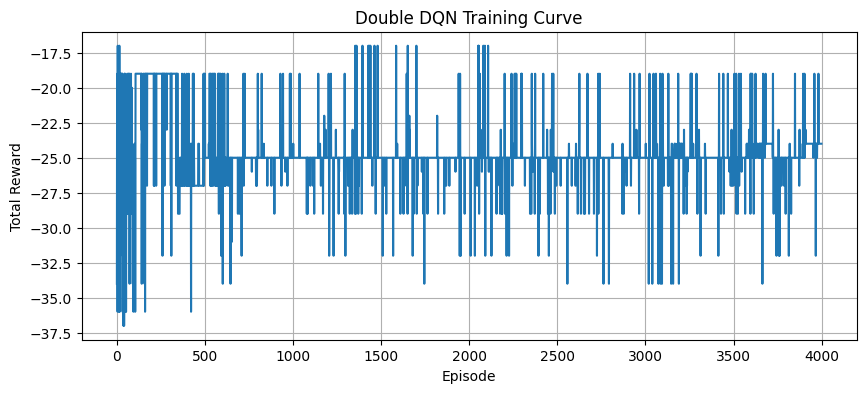

In [19]:
# Cell 4: Double DQN 학습 루프 + 학습 실행

def train_double_dqn(
    episodes=4000,
    max_steps=60,
    target_update_interval=200,
    verbose_interval=500,
    seed=0,
):
    set_seed(seed)
    env = BusEnv(max_steps=max_steps)
    agent = DoubleDQNAgent(state_dim=env.state_dim, action_dim=TOTAL_ACTION_DIM)

    episode_rewards = []

    for ep in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0.0

        for t in range(max_steps):
            available_actions = env.get_available_actions()
            if len(available_actions) == 0:
                break

            action = agent.select_action(state, available_actions, greedy=False)
            next_state, reward, done, info = env.step(action)

            agent.push_transition(state, action, reward, next_state, done)
            agent.train_step()
            agent.update_epsilon()

            total_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)

        if verbose_interval and ep % verbose_interval == 0:
            print(
                f"Episode {ep}/{episodes}, "
                f"reward={total_reward:.1f}, "
                f"eps={agent.epsilon:.3f}, "
                f"success={info['success']}"
            )

        if agent.train_steps and agent.train_steps % target_update_interval == 0:
            agent.update_target()

    return env, agent, episode_rewards


# ---- 실제 학습 실행 ----
env, agent, rewards = train_double_dqn(
    episodes=4000,
    max_steps=60,
    seed=0,
)

# 학습 곡선 시각화 (영문만 사용해서 폰트 문제 회피)
plt.figure(figsize=(10,4))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Double DQN Training Curve")
plt.grid(True)
plt.show()


In [25]:
# Cell 5: 학습된 정책으로 실제 경로 시뮬레이션

def simulate_route(env, agent, start_time=0, max_steps=60):
    """
    start_time: 출발 시점 (분). 버스 ETA 계산에 영향을 줌.
    """
    state = env.reset()
    # 출발 시각 직접 세팅
    env.current_time = start_time
    env.total_time = 0
    env.total_walk = 0
    env.total_wait = 0
    env.total_ride = 0

    print(f"=== 시뮬레이션 시작 (start_time={start_time}분) ===")

    for step in range(1, max_steps + 1):
        available_actions = env.get_available_actions()
        if len(available_actions) == 0:
            print("선택 가능한 행동이 없습니다. 종료합니다.")
            break

        # 평가 시에는 greedy=True로 항상 가장 좋은 행동 선택
        action_idx = agent.select_action(env._build_state(), available_actions, greedy=True)
        action = ACTIONS[action_idx]

        prev_stop = ID_TO_STOP[env.current_stop]
        prev_time = env.current_time
        prev_walk = env.total_walk
        prev_wait = env.total_wait
        prev_ride = env.total_ride

        next_state, reward, done, info = env.step(action_idx)

        dt = env.total_time - prev_time
        dw = env.total_walk - prev_walk
        dwait = env.total_wait - prev_wait
        dr = env.total_ride - prev_ride

        if action["type"] == "walk":
            print(
                f"[{step:02d}] {prev_stop} -> {ID_TO_STOP[action['to']]} "
                f"(도보 {dw}분, 소요 {dt}분, 보상 {reward:.1f})"
            )
        else:
            print(
                f"[{step:02d}] {prev_stop} -> {ID_TO_STOP[action['to']]} "
                f"(버스 {action['line']} 대기 {dwait}분 + 탑승 {dr}분 = {dt}분, 보상 {reward:.1f})"
            )

        if done:
            print(
                f"*** 에피소드 종료 ***\n"
                f"현재 정류장: {info['cur_stop']}\n"
                f"총 시간: {info['total_time']}분\n"
                f"총 도보: {info['total_walk']}분\n"
                f"총 대기: {info['total_wait']}분\n"
                f"총 탑승: {info['total_ride']}분\n"
                f"목적지 도달: {info['success']}"
            )
            break


# 예시: 출발 시각 0분 기준으로 경로 시뮬레이션
simulate_route(env, agent, start_time=0, max_steps=60)


=== 시뮬레이션 시작 (start_time=0분) ===
[01] 집 -> 후암시장 정류장 (도보 3분, 소요 3분, 보상 -3.0)
[02] 후암시장 정류장 -> 남영우체국 정류장 (버스 605 대기 7분 + 탑승 4분 = 11분, 보상 -11.0)
[03] 남영우체국 정류장 -> 갈월동사회복지회관 정류장 (도보 1분, 소요 1분, 보상 -1.0)
[04] 갈월동사회복지회관 정류장 -> 남영동 정류장 (버스 용산02 대기 0분 + 탑승 4분 = 4분, 보상 -4.0)
[05] 남영동 정류장 -> 원효로3가 정류장 (버스 162 대기 5분 + 탑승 8분 = 13분, 보상 -13.0)
[06] 원효로3가 정류장 -> 목적지 (도보 7분, 소요 7분, 보상 8.0)
*** 에피소드 종료 ***
현재 정류장: 목적지
총 시간: 39분
총 도보: 11분
총 대기: 12분
총 탑승: 16분
목적지 도달: True


알고리즘 비교


In [26]:
# Cell 6: Random / Greedy / Simple DQN Agents

class RandomAgent:
    def select_action(self, state, available_actions, greedy=False):
        # greedy 인자는 무시 (통일된 인터페이스를 위해 둠)
        return random.choice(available_actions)


class GreedyTimeAgent:
    """
    매 순간, (대기시간 + 탑승시간) 또는 도보시간이
    최소가 되는 행동을 고르는 휴리스틱 에이전트.
    - wait, ride, walk 모두 '시간' 관점에서만 본다.
    - 실제 ETA 계산을 위해 env 참조 필요 → 매 에피소드마다 set_env()로 설정.
    """
    def __init__(self):
        self.env = None  # 현재 에피소드의 env

    def set_env(self, env):
        self.env = env

    def select_action(self, state, available_actions, greedy=False):
        assert self.env is not None, "env가 설정되지 않았습니다. set_env(env)를 먼저 호출해야 합니다."

        best_a = None
        best_cost = float("inf")

        for a_idx in available_actions:
            a = ACTIONS[a_idx]
            if a["type"] == "walk":
                cost = a["walk"]
            else:
                # 버스: 대기 + 탑승
                wait = self.env._eta_for_line(a["line"])
                cost = wait + a["ride"]

            if cost < best_cost:
                best_cost = cost
                best_a = a_idx

        # 혹시라도 available_actions가 비었으면 (안전장치)
        if best_a is None:
            best_a = random.choice(available_actions)

        return best_a


# Simple DQN (Double 아님)
class SimpleDQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.98,
        lr=1e-3,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        batch_size=64,
        buffer_capacity=20000,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.online = DQNNet(state_dim, action_dim).to(device)
        self.target = DQNNet(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, available_actions, greedy=False):
        if len(available_actions) == 0:
            return 0

        # 학습 중(epsilon-greedy) vs 평가(greedy=True)
        use_eps = (not greedy)
        if use_eps and (random.random() < self.epsilon):
            return random.choice(available_actions)

        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.online(state_t)[0].cpu().numpy()

        best_action = max(available_actions, key=lambda a: q_values[a])
        return best_action

    def push_transition(self, *args):
        self.buffer.push(*args)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return None

        batch = self.buffer.sample(self.batch_size)

        states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        q_values = self.online(states).gather(1, actions)

        with torch.no_grad():
            # Simple DQN: target net에서 바로 max
            next_q_target = self.target(next_states)
            next_q, _ = next_q_target.max(dim=1, keepdim=True)
            target = rewards + self.gamma * (1 - dones) * next_q

        loss = nn.functional.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_steps += 1
        return loss.item()

    def update_target(self):
        self.target.load_state_dict(self.online.state_dict())


[SimpleDQN] Episode 500/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 1000/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 1500/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 2000/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 2500/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 3000/4000, reward=-25.0, eps=0.050, success=True
[SimpleDQN] Episode 3500/4000, reward=-17.0, eps=0.050, success=True
[SimpleDQN] Episode 4000/4000, reward=-27.0, eps=0.050, success=True
Episode 500/4000, reward=-25.0, eps=0.050, success=True
Episode 1000/4000, reward=-25.0, eps=0.050, success=True
Episode 1500/4000, reward=-25.0, eps=0.050, success=True
Episode 2000/4000, reward=-25.0, eps=0.050, success=True
Episode 2500/4000, reward=-25.0, eps=0.050, success=True
Episode 3000/4000, reward=-25.0, eps=0.050, success=True
Episode 3500/4000, reward=-25.0, eps=0.050, success=True
Episode 4000/4000, reward=-24.0, eps=0.050, success

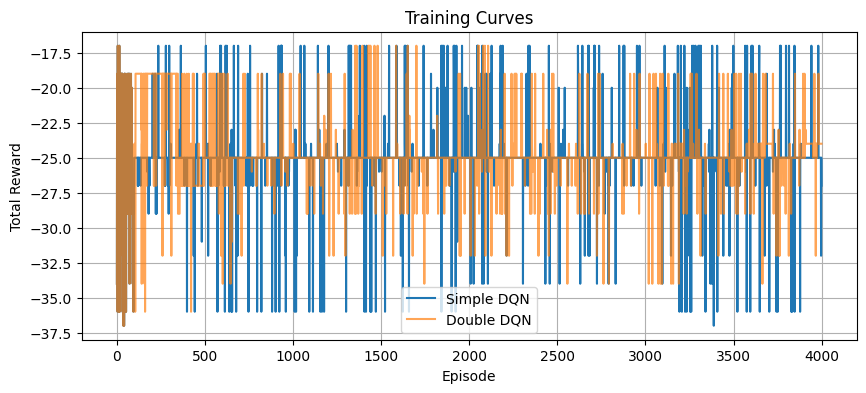

In [27]:
# Cell 7: Simple DQN & Double DQN 학습 함수 및 학습 실행

def train_simple_dqn(
    episodes=4000,
    max_steps=60,
    target_update_interval=200,
    verbose_interval=500,
    seed=0,
):
    set_seed(seed)
    env = BusEnv(max_steps=max_steps)
    agent = SimpleDQNAgent(state_dim=env.state_dim, action_dim=TOTAL_ACTION_DIM)

    episode_rewards = []

    for ep in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0.0

        for t in range(max_steps):
            available_actions = env.get_available_actions()
            if len(available_actions) == 0:
                break

            action = agent.select_action(state, available_actions, greedy=False)
            next_state, reward, done, info = env.step(action)

            agent.push_transition(state, action, reward, next_state, done)
            agent.train_step()
            agent.update_epsilon()

            total_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)

        if verbose_interval and ep % verbose_interval == 0:
            print(
                f"[SimpleDQN] Episode {ep}/{episodes}, "
                f"reward={total_reward:.1f}, eps={agent.epsilon:.3f}, success={info['success']}"
            )

        if agent.train_steps and agent.train_steps % target_update_interval == 0:
            agent.update_target()

    return env, agent, episode_rewards


# 이미 정의되어 있는 train_double_dqn(env, agent, ...) 사용
# 앞에서 만든 DoubleDQNAgent와 동일 인터페이스라고 가정

# --- 실제 학습 실행 ---

simple_env, simple_agent, simple_rewards = train_simple_dqn(
    episodes=4000,
    max_steps=60,
    seed=0,
)

double_env, double_agent, double_rewards = train_double_dqn(
    episodes=4000,
    max_steps=60,
    seed=0,
)

# 간단히 학습 곡선 두 개 정도만 확인 (영문 라벨로)
plt.figure(figsize=(10,4))
plt.plot(simple_rewards, label="Simple DQN")
plt.plot(double_rewards, label="Double DQN", alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Curves")
plt.legend()
plt.grid(True)
plt.show()


=== Random ===
mean_reward     = -25.770 ± 6.004
mean_total_time = 36.895
mean_walk_time  = 15.510
mean_wait_time  = 7.865
success_rate    = 0.960

=== Greedy ===
mean_reward     = -29.000 ± 0.000
mean_total_time = 39.000
mean_walk_time  = 16.000
mean_wait_time  = 9.000
success_rate    = 1.000

=== DQN ===
mean_reward     = -25.000 ± 0.000
mean_total_time = 45.000
mean_walk_time  = 8.000
mean_wait_time  = 19.000
success_rate    = 1.000

=== DoubleDQN ===
mean_reward     = -24.000 ± 0.000
mean_total_time = 39.000
mean_walk_time  = 11.000
mean_wait_time  = 12.000
success_rate    = 1.000



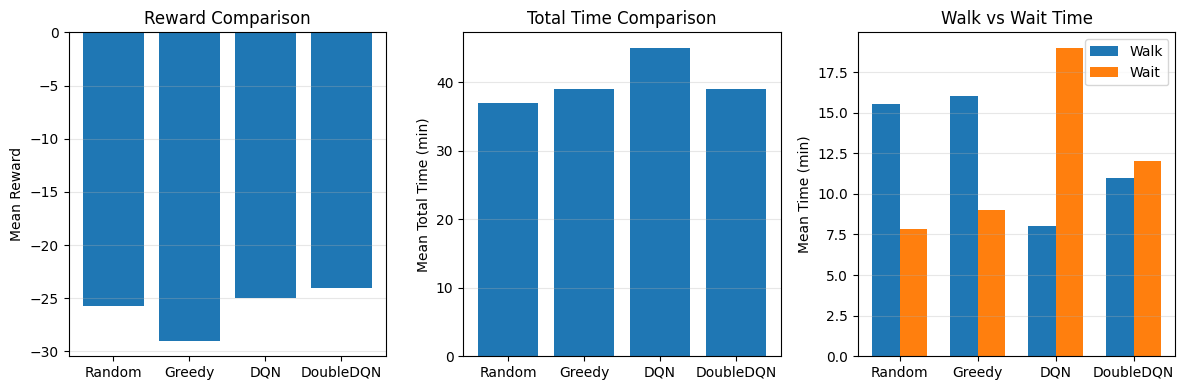

In [28]:
# Cell 8: 여러 알고리즘 평가 및 비교 시각화

def evaluate_agent_policy(
    agent,
    episodes=200,
    max_steps=60,
    seed=123,
):
    """
    - RandomAgent, GreedyTimeAgent, SimpleDQNAgent, DoubleDQNAgent 모두 지원
    - DQN 계열은 greedy=True로 평가 (epsilon=0 행동)
    """
    set_seed(seed)

    rewards = []
    total_times = []
    walk_times = []
    wait_times = []
    success_flags = []

    for ep in range(episodes):
        env = BusEnv(max_steps=max_steps)

        # GreedyTimeAgent는 env가 필요하므로 여기서 연결
        if isinstance(agent, GreedyTimeAgent):
            agent.set_env(env)

        state = env.reset()
        total_reward = 0.0
        last_info = {}

        for t in range(max_steps):
            available_actions = env.get_available_actions()
            if len(available_actions) == 0:
                break

            # DQN 계열은 greedy=True, 나머지는 greedy=False (무시되어도 됨)
            if isinstance(agent, (SimpleDQNAgent, DoubleDQNAgent)):
                action = agent.select_action(state, available_actions, greedy=True)
            else:
                action = agent.select_action(state, available_actions, greedy=False)

            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            last_info = info

            if done:
                break

        rewards.append(total_reward)
        if last_info:
            total_times.append(last_info.get("total_time", 0.0))
            walk_times.append(last_info.get("total_walk", 0.0))
            wait_times.append(last_info.get("total_wait", 0.0))
            success_flags.append(1 if last_info.get("success", False) else 0)

    metrics = {
        "mean_reward": float(np.mean(rewards)),
        "std_reward": float(np.std(rewards)),
        "mean_total_time": float(np.mean(total_times)) if total_times else None,
        "std_total_time": float(np.std(total_times)) if total_times else None,
        "mean_walk_time": float(np.mean(walk_times)) if walk_times else None,
        "mean_wait_time": float(np.mean(wait_times)) if wait_times else None,
        "success_rate": float(np.mean(success_flags)) if success_flags else None,
    }
    return metrics


# --- 에이전트 인스턴스 생성 ---

random_agent = RandomAgent()
greedy_agent = GreedyTimeAgent()
# simple_agent, double_agent 는 Cell 7에서 이미 학습 완료된 상태

# --- 평가 실행 ---

random_metrics  = evaluate_agent_policy(random_agent,  episodes=200, max_steps=60, seed=1)
greedy_metrics  = evaluate_agent_policy(greedy_agent,  episodes=200, max_steps=60, seed=1)
simple_metrics  = evaluate_agent_policy(simple_agent,  episodes=200, max_steps=60, seed=1)
double_metrics  = evaluate_agent_policy(double_agent,  episodes=200, max_steps=60, seed=1)

all_metrics = {
    "Random": random_metrics,
    "Greedy": greedy_metrics,
    "DQN": simple_metrics,
    "DoubleDQN": double_metrics,
}

for name, m in all_metrics.items():
    print(f"=== {name} ===")
    print(f"mean_reward     = {m['mean_reward']:.3f} ± {m['std_reward']:.3f}")
    print(f"mean_total_time = {m['mean_total_time']:.3f}")
    print(f"mean_walk_time  = {m['mean_walk_time']:.3f}")
    print(f"mean_wait_time  = {m['mean_wait_time']:.3f}")
    print(f"success_rate    = {m['success_rate']:.3f}")
    print()


# --- 시각화 (영문 라벨) ---

algo_names = list(all_metrics.keys())

mean_rewards = [all_metrics[a]["mean_reward"] for a in algo_names]
mean_total_times = [all_metrics[a]["mean_total_time"] for a in algo_names]
mean_walk_times = [all_metrics[a]["mean_walk_time"] for a in algo_names]
mean_wait_times = [all_metrics[a]["mean_wait_time"] for a in algo_names]

x = np.arange(len(algo_names))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.bar(x, mean_rewards)
plt.xticks(x, algo_names)
plt.ylabel("Mean Reward")
plt.title("Reward Comparison")
plt.grid(axis="y", alpha=0.3)

plt.subplot(1,3,2)
plt.bar(x, mean_total_times)
plt.xticks(x, algo_names)
plt.ylabel("Mean Total Time (min)")
plt.title("Total Time Comparison")
plt.grid(axis="y", alpha=0.3)

plt.subplot(1,3,3)
width = 0.35
plt.bar(x - width/2, mean_walk_times, width=width, label="Walk")
plt.bar(x + width/2, mean_wait_times, width=width, label="Wait")
plt.xticks(x, algo_names)
plt.ylabel("Mean Time (min)")
plt.title("Walk vs Wait Time")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


2트 버스시간 랜덤 추가

In [42]:
# Cell 1: 기본 세팅 & 정류장 / 버스 정보

import numpy as np
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# -------------------------
# 정류장 목록
# -------------------------
STOPS = [
    "집",
    "후암시장 정류장",
    "갈월동 정류장",
    "남영우체국 정류장",
    "갈월동사회복지회관 정류장",
    "숙명여대입구 정류장",
    "청파동주민센터",
    "숙명여대후문 정류장",
    "효창공원역 정류장",
    "남영동 정류장",
    "용문시장 정류장",
    "원효로2가 정류장",
    "원효로3가 정류장",
    "신용산역(중앙) 정류장",
    "신용산역 3번출구 정류장",
    "용산역광장 정류장",
    "한강대교북단(LGU+) 정류장",
    "한강대교북단 정류장",
    "원효대교북단 정류장",
    "신창동 정류장",
    "성심여고 정류장",
    "목적지",
]

STOP_TO_ID = {name: i for i, name in enumerate(STOPS)}
ID_TO_STOP = {i: name for name, i in STOP_TO_ID.items()}

# -------------------------
# 도보 간선 (단방향)
# -------------------------
WALK_EDGES_RAW = [
    ("집", "후암시장 정류장", 3),
    ("집", "갈월동 정류장", 11),

    ("남영우체국 정류장", "갈월동사회복지회관 정류장", 1),
    ("숙명여대입구 정류장", "청파동주민센터", 3),

    ("신용산역(중앙) 정류장", "신용산역 3번출구 정류장", 2),
    ("신용산역(중앙) 정류장", "용산역광장 정류장", 2),

    ("원효로2가 정류장", "용문시장 정류장", 2),

    ("용문시장 정류장", "목적지", 12),
    ("신창동 정류장", "목적지", 2),
    ("원효로3가 정류장", "목적지", 7),
    ("효창공원역 정류장", "목적지", 15),
    ("성심여고 정류장", "목적지", 1),
    ("원효대교북단 정류장", "목적지", 10),
]

WALK_EDGES = [
    (STOP_TO_ID[s1], STOP_TO_ID[s2], t)
    for (s1, s2, t) in WALK_EDGES_RAW
]

# -------------------------
# 버스 배차간격
# -------------------------
BUS_INTERVAL = {
    "400": 11,
    "605": 10,
    "용산02": 5,
    "1711": 7,
    "7016": 9,
    "162": 8,    # 수정 반영
    "503": 13,   # 모두 13
    "262": 10,
    "0411": 14,
    "0017": 13,
    "5012": 13,
    "505": 9,
}

BUS_LINES = list(BUS_INTERVAL.keys())
MAX_INTERVAL = max(BUS_INTERVAL.values())

# -------------------------
# 버스 간선 (단방향)
# -------------------------
BUS_EDGES = []

def add_bus_edge(line, from_stop, to_stop, ride_min):
    BUS_EDGES.append((
        line,
        STOP_TO_ID[from_stop],
        STOP_TO_ID[to_stop],
        ride_min,
    ))

# 400
add_bus_edge("400", "후암시장 정류장", "남영우체국 정류장", 4)
add_bus_edge("400", "후암시장 정류장", "숙명여대입구 정류장", 6)
add_bus_edge("400", "후암시장 정류장", "원효로2가 정류장", 21)
add_bus_edge("400", "후암시장 정류장", "숙명여대후문 정류장", 9)
add_bus_edge("400", "후암시장 정류장", "효창공원역 정류장", 16)

# 605
add_bus_edge("605", "후암시장 정류장", "신용산역(중앙) 정류장", 11)
add_bus_edge("605", "후암시장 정류장", "남영우체국 정류장", 4)
add_bus_edge("605", "후암시장 정류장", "한강대교북단(LGU+) 정류장", 13)

# 용산02
add_bus_edge("용산02", "갈월동사회복지회관 정류장", "남영동 정류장", 4)

# 1711
add_bus_edge("1711", "남영동 정류장", "용문시장 정류장", 6)
add_bus_edge("1711", "갈월동 정류장", "용문시장 정류장", 10)

# 7016
add_bus_edge("7016", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("7016", "남영동 정류장", "원효로3가 정류장", 8)

# 162
add_bus_edge("162", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("162", "남영동 정류장", "원효로3가 정류장", 8)
add_bus_edge("162", "갈월동 정류장", "원효로3가 정류장", 9)

# 503
add_bus_edge("503", "남영동 정류장", "원효로2가 정류장", 6)
add_bus_edge("503", "남영동 정류장", "원효로3가 정류장", 8)
add_bus_edge("503", "갈월동 정류장", "원효로3가 정류장", 9)

# 262
add_bus_edge("262", "청파동주민센터", "원효로3가 정류장", 7)

# 0411
add_bus_edge("0411", "숙명여대후문 정류장", "원효로3가 정류장", 12)

# 0017
add_bus_edge("0017", "신용산역 3번출구 정류장", "신창동 정류장", 12)
add_bus_edge("0017", "한강대교북단 정류장", "성심여고 정류장", 13)
add_bus_edge("0017", "용문시장 정류장", "신창동 정류장", 4)
add_bus_edge("0017", "용산역광장 정류장", "성심여고 정류장", 17)

# 505
add_bus_edge("505", "갈월동 정류장", "원효대교북단 정류장", 11)

# 5012
add_bus_edge("5012", "용산역광장 정류장", "원효대교북단 정류장", 6)

# -------------------------
# ACTIONS & from별 인덱스
# -------------------------
ACTIONS = []

for s1, s2, w in WALK_EDGES:
    ACTIONS.append({"type": "walk", "from": s1, "to": s2, "walk": w})

for line, s1, s2, ride in BUS_EDGES:
    ACTIONS.append({"type": "bus", "line": line, "from": s1, "to": s2, "ride": ride})

TOTAL_ACTION_DIM = len(ACTIONS)

ACTIONS_BY_FROM = {i: [] for i in range(len(STOPS))}
for idx, a in enumerate(ACTIONS):
    ACTIONS_BY_FROM[a["from"]].append(idx)

print("총 정류장 수:", len(STOPS))
print("총 행동 수:", TOTAL_ACTION_DIM)


총 정류장 수: 22
총 행동 수: 40


In [43]:
# Cell 2: BusEnv (bus_phase 랜덤)

class BusEnv:
    def __init__(self, max_steps=60):
        self.max_steps = max_steps
        # 상태: [stop one-hot, total_time/60, bus etas]
        self.state_dim = len(STOPS) + 1 + len(BUS_LINES)
        self.reset()

    def reset(self):
        self.current_stop = STOP_TO_ID["집"]
        self.current_time = 0
        self.total_walk = 0
        self.total_wait = 0
        self.total_ride = 0
        self.total_time = 0
        self.step_count = 0
        self.done = False
        self.success = False

        # 각 노선별 phase를 배차간격 내에서 랜덤
        self.bus_phase = {
            line: np.random.randint(0, BUS_INTERVAL[line])
            for line in BUS_LINES
        }

        return self._build_state()

    def _eta_for_line(self, line_name):
        interval = BUS_INTERVAL[line_name]
        phase = self.bus_phase[line_name]
        eta = (interval - ((self.current_time + phase) % interval)) % interval
        return eta

    def _build_state(self):
        stop_onehot = np.zeros(len(STOPS), dtype=np.float32)
        stop_onehot[self.current_stop] = 1.0

        time_feat = np.array([self.total_time / 60.0], dtype=np.float32)

        etas = []
        for line in BUS_LINES:
            eta = self._eta_for_line(line)
            etas.append(eta / MAX_INTERVAL)
        etas = np.array(etas, dtype=np.float32)

        return np.concatenate([stop_onehot, time_feat, etas])

    def get_available_actions(self):
        return ACTIONS_BY_FROM.get(self.current_stop, [])

    def step(self, action_idx):
        if self.done:
            raise RuntimeError("Episode already done")

        self.step_count += 1
        a = ACTIONS[action_idx]

        add_walk = add_wait = add_ride = 0

        if a["type"] == "walk":
            add_walk = a["walk"]
            dt = add_walk
        else:
            wait = self._eta_for_line(a["line"])
            add_wait = wait
            add_ride = a["ride"]
            dt = add_wait + add_ride

        self.current_time += dt
        self.total_walk += add_walk
        self.total_wait += add_wait
        self.total_ride += add_ride
        self.total_time += dt

        prev_stop = self.current_stop
        self.current_stop = a["to"]

        # 기본 보상: 시간 1분당 -1
        step_cost = add_walk + add_wait + add_ride
        reward = -float(step_cost)

        # 종료 조건
        if self.current_stop == STOP_TO_ID["목적지"]:
            self.done = True
            self.success = True

        if self.step_count >= self.max_steps:
            self.done = True

        if self.done:
            # 도보 10분을 초과하면 5분 단위로 패널티
            if self.total_walk > 10:
                over = self.total_walk - 10
                blocks = int((over - 1) // 5) + 1  # 1~5,6~10, ...
                reward -= 5 * blocks

            if not self.success:
                reward -= 20.0  # 혹시 실패 시

        info = {
            "prev_stop": ID_TO_STOP[prev_stop],
            "cur_stop": ID_TO_STOP[self.current_stop],
            "total_time": self.total_time,
            "total_walk": self.total_walk,
            "total_wait": self.total_wait,
            "total_ride": self.total_ride,
            "success": self.success,
            "action": a,
        }

        next_state = self._build_state()
        return next_state, reward, self.done, info

    def print_bus_state(self):
        print("=== 출발 시점 버스 상태(ETA, 분) ===")
        for line in BUS_LINES:
            print(f"{line}: {self._eta_for_line(line)}분")
        print()


Episode 500/5000, reward=-41.0, eps=0.050, success=True
Episode 1000/5000, reward=-29.0, eps=0.050, success=True
Episode 1500/5000, reward=-36.0, eps=0.050, success=True
Episode 2000/5000, reward=-45.0, eps=0.050, success=True
Episode 2500/5000, reward=-37.0, eps=0.050, success=True
Episode 3000/5000, reward=-30.0, eps=0.050, success=True
Episode 3500/5000, reward=-36.0, eps=0.050, success=True
Episode 4000/5000, reward=-38.0, eps=0.050, success=True
Episode 4500/5000, reward=-36.0, eps=0.050, success=True
Episode 5000/5000, reward=-37.0, eps=0.050, success=True


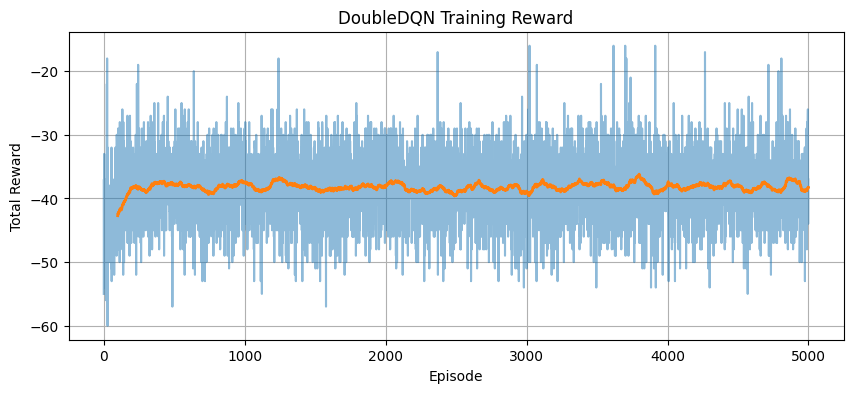

In [35]:
# Cell 3: DoubleDQN 정의 & 학습

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*batch))
        return batch

    def __len__(self):
        return len(self.buffer)


class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_dim),
        )

    def forward(self, x):
        return self.net(x)


class DoubleDQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.98,
        lr=1e-3,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        batch_size=64,
        buffer_capacity=20000,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size

        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.online = DQNNet(state_dim, action_dim).to(device)
        self.target = DQNNet(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, available_actions, greedy=False):
        if len(available_actions) == 0:
            return 0

        eps = 0.0 if greedy else self.epsilon
        if random.random() < eps:
            return random.choice(available_actions)

        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.online(state_t)[0].cpu().numpy()

        best_action = max(available_actions, key=lambda a: q_values[a])
        return best_action

    def push(self, *args):
        self.buffer.push(*args)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return None

        batch = self.buffer.sample(self.batch_size)

        states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

        q_values = self.online(states).gather(1, actions)

        with torch.no_grad():
            # Double DQN
            next_q_online = self.online(next_states)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)
            next_q_target = self.target(next_states)
            next_q = next_q_target.gather(1, next_actions)

            target = rewards + self.gamma * (1 - dones) * next_q

        loss = nn.functional.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_steps += 1
        return loss.item()

    def update_target(self):
        self.target.load_state_dict(self.online.state_dict())


def train_double_dqn(
    episodes=5000,
    max_steps=60,
    target_update_interval=200,
    seed=0,
    verbose_interval=500,
):
    set_seed(seed)
    env = BusEnv(max_steps=max_steps)
    agent = DoubleDQNAgent(state_dim=env.state_dim, action_dim=TOTAL_ACTION_DIM)

    rewards = []

    for ep in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0.0
        last_info = {}

        for t in range(max_steps):
            available = env.get_available_actions()
            if not available:
                break

            action = agent.select_action(state, available, greedy=False)
            next_state, reward, done, info = env.step(action)

            agent.push(state, action, reward, next_state, done)
            agent.train_step()
            agent.update_epsilon()

            total_reward += reward
            state = next_state
            last_info = info

            if done:
                break

        rewards.append(total_reward)

        if verbose_interval and ep % verbose_interval == 0:
            print(
                f"Episode {ep}/{episodes}, "
                f"reward={total_reward:.1f}, eps={agent.epsilon:.3f}, "
                f"success={last_info.get('success', False)}"
            )

        if agent.train_steps and agent.train_steps % target_update_interval == 0:
            agent.update_target()

    return env, agent, rewards


# 실제 학습 실행
env_tr, agent_tr, ep_rewards = train_double_dqn(
    episodes=5000,
    max_steps=60,
    seed=0,
)

plt.figure(figsize=(10,4))
plt.plot(ep_rewards, alpha=0.5)
window = 100
if len(ep_rewards) > window:
    ma = np.convolve(ep_rewards, np.ones(window)/window, mode="valid")
    plt.plot(range(window-1, window-1+len(ma)), ma, linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DoubleDQN Training Reward")
plt.grid(True)
plt.show()


In [36]:
# Cell 4: 학습된 DoubleDQN으로 1회 시뮬레이션

def simulate_route_with_doubledqn(agent, max_steps=60, seed=123):
    set_seed(seed)
    env = BusEnv(max_steps=max_steps)
    state = env.reset()

    print("=== 시뮬레이션 시작 ===")
    env.print_bus_state()

    step = 0
    while True:
        available = env.get_available_actions()
        if not available:
            print("선택 가능한 행동 없음 → 종료")
            break

        action_idx = agent.select_action(state, available, greedy=True)
        a = ACTIONS[action_idx]

        prev_stop = ID_TO_STOP[env.current_stop]
        next_state, reward, done, info = env.step(action_idx)

        step += 1
        if a["type"] == "walk":
            print(f"[{step:02d}] {prev_stop} -> {info['cur_stop']} "
                  f"(도보 {a['walk']}분, 소요 {a['walk']}분, 보상 {reward:.1f})")
        else:
            wait = info["total_wait"] - (env.total_wait - (a["ride"]))  # rough
            # 위 한 줄은 정확한 step별 wait 추적이 어려워서 간단 표시용이므로,
            # 그냥 ETA 다시 계산해도 됨 (로그용이니 너무 신경 안 써도 됨)
            eta_now = env._eta_for_line(a["line"])  # 이동 후 시점 기준
            print(f"[{step:02d}] {prev_stop} -> {info['cur_stop']} "
                  f"(버스 {a['line']} 탑승, 소요 {a['ride']}분, 보상 {reward:.1f})")

        state = next_state

        if done:
            print("\n*** 에피소드 종료 ***")
            print(f"현재 정류장: {info['cur_stop']}")
            print(f"총 시간: {info['total_time']}분")
            print(f"총 도보: {info['total_walk']}분")
            print(f"총 대기: {info['total_wait']}분")
            print(f"총 탑승: {info['total_ride']}분")
            print(f"목적지 도달: {info['success']}")
            break


# 학습된 agent_tr 사용해서 1회 시뮬레이션
simulate_route_with_doubledqn(agent_tr, max_steps=60, seed=42)


=== 시뮬레이션 시작 ===
=== 출발 시점 버스 상태(ETA, 분) ===
400: 7분
605: 7분
용산02: 3분
1711: 2분
7016: 5분
162: 7분
503: 6분
262: 5분
0411: 13분
0017: 2분
5012: 9분
505: 0분

[01] 집 -> 후암시장 정류장 (도보 3분, 소요 3분, 보상 -3.0)
[02] 후암시장 정류장 -> 남영우체국 정류장 (버스 400 탑승, 소요 4분, 보상 -8.0)
[03] 남영우체국 정류장 -> 갈월동사회복지회관 정류장 (도보 1분, 소요 1분, 보상 -1.0)
[04] 갈월동사회복지회관 정류장 -> 남영동 정류장 (버스 용산02 탑승, 소요 4분, 보상 -5.0)
[05] 남영동 정류장 -> 원효로2가 정류장 (버스 503 탑승, 소요 6분, 보상 -8.0)
[06] 원효로2가 정류장 -> 용문시장 정류장 (도보 2분, 소요 2분, 보상 -2.0)
[07] 용문시장 정류장 -> 신창동 정류장 (버스 0017 탑승, 소요 4분, 보상 -5.0)
[08] 신창동 정류장 -> 목적지 (도보 2분, 소요 2분, 보상 -2.0)

*** 에피소드 종료 ***
현재 정류장: 목적지
총 시간: 34분
총 도보: 8분
총 대기: 8분
총 탑승: 18분
목적지 도달: True


도보 패널티를 늘리기 시도

도보 10분 초과 시

5분 단위마다 -5 * 블록수 패널티 => -10* 블록수 패널티




[기본환경] Episode 1000/4000, reward=-29.0, eps=0.050
[기본환경] Episode 2000/4000, reward=-45.0, eps=0.050
[기본환경] Episode 3000/4000, reward=-30.0, eps=0.050
[기본환경] Episode 4000/4000, reward=-38.0, eps=0.050

[도보초강력패널티] Episode 1000/4000, reward=-117.0, eps=0.050
[도보초강력패널티] Episode 2000/4000, reward=-116.1, eps=0.050
[도보초강력패널티] Episode 3000/4000, reward=-114.9, eps=0.050
[도보초강력패널티] Episode 4000/4000, reward=-117.0, eps=0.050

=== DoubleDQN 환경 비교 결과 ===
[기본환경] 보상=-37.10, 총시간=37.10, 도보=7.17, 대기=11.93, 성공률=1.000
[도보초강력패널티] 보상=-112.90, 총시간=39.26, 도보=17.70, 대기=5.51, 성공률=1.000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


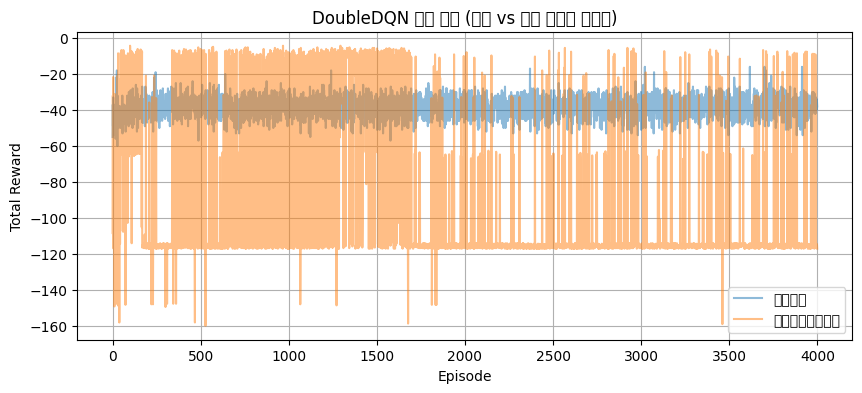


=== 기본환경 정책 시뮬레이션 (seed=42) ===
=== 출발 시점 버스 상태(ETA, 분) ===
400: 7분
605: 7분
용산02: 3분
1711: 2분
7016: 5분
162: 7분
503: 6분
262: 5분
0411: 13분
0017: 2분
5012: 9분
505: 0분

[01] 집 → 후암시장 정류장 (도보 3분, 소요 3분, 누적시간 3분, 보상 -3.0)
[02] 후암시장 정류장 → 남영우체국 정류장 (버스 400, 대기 4분 + 탑승 4분 = 8분, 누적시간 11분, 보상 -8.0)
[03] 남영우체국 정류장 → 갈월동사회복지회관 정류장 (도보 1분, 소요 1분, 누적시간 12분, 보상 -1.0)
[04] 갈월동사회복지회관 정류장 → 남영동 정류장 (버스 용산02, 대기 1분 + 탑승 4분 = 5분, 누적시간 17분, 보상 -5.0)
[05] 남영동 정류장 → 원효로2가 정류장 (버스 503, 대기 2분 + 탑승 6분 = 8분, 누적시간 25분, 보상 -8.0)
[06] 원효로2가 정류장 → 용문시장 정류장 (도보 2분, 소요 2분, 누적시간 27분, 보상 -2.0)
[07] 용문시장 정류장 → 신창동 정류장 (버스 0017, 대기 1분 + 탑승 4분 = 5분, 누적시간 32분, 보상 -5.0)
[08] 신창동 정류장 → 목적지 (도보 2분, 소요 2분, 누적시간 34분, 보상 -2.0)

*** 에피소드 종료 ***
현재 정류장: 목적지
총 시간: 34분
총 도보: 8분
총 대기: 8분
총 탑승: 18분
목적지 도달: True

=== 도보초강력패널티 정책 시뮬레이션 (seed=42) ===
=== 출발 시점 버스 상태(ETA, 분) ===
400: 7분
605: 7분
용산02: 3분
1711: 2분
7016: 5분
162: 7분
503: 6분
262: 5분
0411: 13분
0017: 2분
5012: 9분
505: 0분

[01] 집 → 후암시장 정류장 (도보 3분, 소요 3분, 누적시간 3분, 보상 -18.0)
[02] 후암

In [40]:
# === Cell X: 도보 초강력 패널티 환경 vs 기본 환경 DoubleDQN 비교 + 경로 출력 ===

import numpy as np
import matplotlib.pyplot as plt

# 1) 도보 초강력 패널티 버전 환경
class BusEnvWalkUltraHeavy(BusEnv):
    """
    - step 단위:
        ride: 1배
        wait: 0.3배
        walk: 6배 (도보 극혐)
    - 종료 시:
        total_walk > 10이면,
        5분 초과 블록마다 -20 * blocks 페널티
    """
    def step(self, action_idx: int):
        assert not self.done, "Episode is done. Call reset()."

        self.step_count += 1
        action = ACTIONS[action_idx]

        reward = 0.0
        add_walk = 0
        add_wait = 0
        add_ride = 0

        # --- 이동 시간 계산 ---
        if action["type"] == "walk":
            w = action["walk"]
            add_walk = w
            dt = w
        else:
            line = action["line"]
            ride = action["ride"]
            wait = self._eta_for_line(line)
            add_wait = wait
            add_ride = ride
            dt = wait + ride

        # --- 시간 / 누적량 업데이트 ---
        self.current_time += dt
        self.total_walk += add_walk
        self.total_wait += add_wait
        self.total_ride += add_ride
        self.total_time += dt

        # 위치 이동
        self.current_stop = action["to"]

        # --- 보상 설계 (walk에 매우 큰 가중치) ---
        step_cost = add_ride + 0.3 * add_wait + 6.0 * add_walk
        reward -= step_cost

        # 목표 도달 여부
        if self.current_stop == STOP_TO_ID["목적지"]:
            self.done = True
            self.success = True
            reward += 50.0  # 성공 보너스는 동일하게 유지

        # 최대 스텝 초과
        if self.step_count >= self.max_steps:
            self.done = True

        # --- 에피소드 종료 시 추가 패널티 ---
        if self.done:
            # 총 도보 10분 초과 시, 5분 블록당 -20
            if self.total_walk > 10:
                over = self.total_walk - 10
                blocks = int((over - 1) // 5) + 1  # 11~15 →1, 16~20 →2 ...
                reward -= 20.0 * blocks

            # 실패 시 추가 패널티
            if not self.success:
                reward -= 20.0

        next_state = self._build_state()
        info = {
            "cur_stop": ID_TO_STOP[self.current_stop],
            "total_time": self.total_time,
            "total_walk": self.total_walk,
            "total_wait": self.total_wait,
            "total_ride": self.total_ride,
            "success": self.success,
        }
        return next_state, reward, self.done, info


# 2) 공통: 학습 + 평가 함수 (DoubleDQN 기준)

def train_and_eval_doubledqn(
    env_cls,
    label,
    gamma=0.98,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    episodes=4000,
    max_steps=60,
    eval_episodes=200,
    seed=0,
):
    """
    env_cls : 사용할 환경 클래스 (BusEnv 또는 BusEnvWalkUltraHeavy)
    label   : 로그/그래프용 이름
    """
    set_seed(seed)
    env = env_cls(max_steps=max_steps)

    agent = DoubleDQNAgent(
        state_dim=env.state_dim,
        action_dim=TOTAL_ACTION_DIM,
        gamma=gamma,
        lr=lr,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        epsilon_decay=epsilon_decay,
    )

    episode_rewards = []

    # ------- 학습 -------
    for ep in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0.0

        for t in range(max_steps):
            available = env.get_available_actions()
            if not available:
                break

            action = agent.select_action(state, available, greedy=False)
            next_state, reward, done, info = env.step(action)

            agent.push(state, action, reward, next_state, done)
            agent.train_step()
            agent.update_epsilon()

            total_reward += reward
            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)

        if ep % max(1, episodes // 4) == 0:
            print(f"[{label}] Episode {ep}/{episodes}, "
                  f"reward={total_reward:.1f}, eps={agent.epsilon:.3f}")

        if agent.train_steps and agent.train_steps % 200 == 0:
            agent.update_target()

    # ------- 평가 (greedy) -------
    set_seed(seed + 100)
    env_eval = env_cls(max_steps=max_steps)

    rewards = []
    total_times = []
    walk_times = []
    wait_times = []
    success_flags = []

    old_eps = agent.epsilon
    agent.epsilon = 0.0

    for ep in range(eval_episodes):
        state = env_eval.reset()
        total_reward = 0.0
        last_info = {}

        for t in range(max_steps):
            available = env_eval.get_available_actions()
            if not available:
                break

            action = agent.select_action(state, available, greedy=True)
            next_state, reward, done, info = env_eval.step(action)
            total_reward += reward
            state = next_state
            last_info = info

            if done:
                break

        rewards.append(total_reward)
        if last_info:
            total_times.append(last_info["total_time"])
            walk_times.append(last_info["total_walk"])
            wait_times.append(last_info["total_wait"])
            success_flags.append(1 if last_info["success"] else 0)

    agent.epsilon = old_eps

    metrics = {
        "label": label,
        "mean_reward": float(np.mean(rewards)),
        "mean_time": float(np.mean(total_times)),
        "mean_walk": float(np.mean(walk_times)),
        "mean_wait": float(np.mean(wait_times)),
        "success_rate": float(np.mean(success_flags)),
        "train_rewards": episode_rewards,
    }

    return agent, metrics


# 3) 두 설정 학습 & 평가
# A: 기본 환경 (BusEnv)
agent_A, metrics_A = train_and_eval_doubledqn(
    env_cls=BusEnv,
    label="기본환경",
    gamma=0.98,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    episodes=4000,
    max_steps=60,
    eval_episodes=200,
    seed=0,
)

print()
# B: 도보 초강력 패널티 환경 (BusEnvWalkUltraHeavy)
agent_B, metrics_B = train_and_eval_doubledqn(
    env_cls=BusEnvWalkUltraHeavy,
    label="도보초강력패널티",
    gamma=0.98,      # 여기서는 gamma/lr는 같게 두고 "환경 차이"만 보기
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    episodes=4000,
    max_steps=60,
    eval_episodes=200,
    seed=1,
)

# 4) 결과 비교 출력
print("\n=== DoubleDQN 환경 비교 결과 ===")
for m in [metrics_A, metrics_B]:
    print(f"[{m['label']}] "
          f"보상={m['mean_reward']:.2f}, "
          f"총시간={m['mean_time']:.2f}, "
          f"도보={m['mean_walk']:.2f}, "
          f"대기={m['mean_wait']:.2f}, "
          f"성공률={m['success_rate']:.3f}")

# 5) 학습 곡선 비교 그래프
plt.figure(figsize=(10,4))
plt.plot(metrics_A["train_rewards"], alpha=0.5, label="기본환경")
plt.plot(metrics_B["train_rewards"], alpha=0.5, label="도보초강력패널티")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DoubleDQN 학습 곡선 (기본 vs 도보 초강력 패널티)")
plt.grid(True)
plt.legend()
plt.show()


# 6) 한 번씩 실제 경로 시뮬레이션해서 출력

def simulate_one_route(env_cls, agent, max_steps=60, seed=123, label=""):
    set_seed(seed)
    env = env_cls(max_steps=max_steps)
    state = env.reset()

    # 출발 시점 버스 상태 출력 (BusEnv에 print_bus_state 있다고 가정)
    print(f"\n=== {label} 정책 시뮬레이션 (seed={seed}) ===")
    env.print_bus_state()

    old_eps = getattr(agent, "epsilon", None)
    if old_eps is not None:
        agent.epsilon = 0.0

    step = 0
    while True:
        available = env.get_available_actions()
        if not available:
            print("선택 가능한 행동 없음 → 종료")
            break

        action_idx = agent.select_action(state, available, greedy=True)
        a = ACTIONS[action_idx]

        prev_stop_id = env.current_stop
        prev_stop_name = ID_TO_STOP[prev_stop_id]
        prev_time = env.current_time

        next_state, reward, done, info = env.step(action_idx)
        state = next_state
        step += 1

        if a["type"] == "walk":
            dt = a["walk"]
            print(
                f"[{step:02d}] {prev_stop_name} → {info['cur_stop']} "
                f"(도보 {a['walk']}분, 소요 {dt}분, "
                f"누적시간 {info['total_time']}분, 보상 {reward:.1f})"
            )
        else:
            line = a["line"]
            interval = BUS_INTERVAL[line]
            phase = env.bus_phase[line]
            wait = (interval - ((prev_time + phase) % interval)) % interval
            ride = a["ride"]
            dt = wait + ride
            print(
                f"[{step:02d}] {prev_stop_name} → {info['cur_stop']} "
                f"(버스 {line}, 대기 {wait}분 + 탑승 {ride}분 = {dt}분, "
                f"누적시간 {info['total_time']}분, 보상 {reward:.1f})"
            )

        if done:
            print("\n*** 에피소드 종료 ***")
            print(f"현재 정류장: {info['cur_stop']}")
            print(f"총 시간: {info['total_time']}분")
            print(f"총 도보: {info['total_walk']}분")
            print(f"총 대기: {info['total_wait']}분")
            print(f"총 탑승: {info['total_ride']}분")
            print(f"목적지 도달: {info['success']}")
            break

    if old_eps is not None:
        agent.epsilon = old_eps


# 기본 환경 정책 경로
simulate_one_route(BusEnv, agent_A, max_steps=60, seed=42, label="기본환경")

# 도보 초강력 패널티 환경 정책 경로
simulate_one_route(BusEnvWalkUltraHeavy, agent_B, max_steps=60, seed=42, label="도보초강력패널티")
